## Finding the start of a flash drought

In [187]:
#importing packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import dask.distributed as dsk

# Start Client/ dask runs together with xarray to improve performance. Only need to initialize once here.
clnt = dsk.Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35733 instead
  warnings.warn(


In [188]:
# path to directory of AWRA model data
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/'


# selecting a time slice and specific latitude and longitude to work on a single grid cell
time_slice = slice('1980-01-01', '2022-12-31')
lat_sel = -30
lon_sel = 145

In [189]:
#load in filtered FD start dates from quantiles method
fd = xr.open_dataset('/g/data/w97/aj8747/fd_summer_project/fd_sm_start.nc')

#check how many FD values you have. ie. how many potential start dates 
fd['sm_pct'].dropna(dim = 'time') 

<xarray.DataArray 'sm_pct' (time: 135)>
array([0.02925 , 0.026486, 0.023987, 0.029149, 0.02642 , 0.023937, 0.021692,
       0.019654, 0.017804, 0.016131, 0.11037 , 0.107352, 0.103579, 0.098982,
       0.094216, 0.090848, 0.088156, 0.084637, 0.080862, 0.077386, 0.074425,
       0.071357, 0.067934, 0.063177, 0.062162, 0.059733, 0.057125, 0.049614,
       0.036849, 0.03505 , 0.043241, 0.040457, 0.052062, 0.046869, 0.101507,
       0.097762, 0.094732, 0.09226 , 0.088716, 0.084563, 0.079732, 0.022342,
       0.021122, 0.054048, 0.065478, 0.059874, 0.054839, 0.034471, 0.032386,
       0.030098, 0.035719, 0.064555, 0.060012, 0.054827, 0.049577, 0.044829,
       0.040534, 0.036686, 0.028589, 0.055879, 0.052395, 0.048865, 0.04542 ,
       0.042015, 0.021668, 0.020176, 0.018827, 0.017595, 0.016463, 0.015887,
       0.015023, 0.046352, 0.042982, 0.040054, 0.036705, 0.03328 , 0.030163,
       0.028201, 0.026863, 0.025205, 0.023612, 0.021923, 0.037357, 0.037875,
       0.03767 , 0.034142, 0.030952, 0.021184, 0.020616, 0.019893, 0.019168,
       0.06306 , 0.059277, 0.064447, 0.058309, 0.052795, 0.054838, 0.048107,
       0.091694, 0.0883  , 0.084676, 0.024842, 0.022974, 0.055057, 0.051227,
       0.047505, 0.046412, 0.045775, 0.043542, 0.040657, 0.037595, 0.04479 ,
       0.042772, 0.040507, 0.038427, 0.04312 , 0.039271, 0.04125 , 0.038013,
       0.034663, 0.06805 , 0.065599, 0.06237 , 0.042709, 0.044728, 0.040273,
       0.036427, 0.059818, 0.054638, 0.049659, 0.025131, 0.02412 , 0.090918,
       0.087407, 0.088735], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-03-22 1980-03-23 ... 2021-07-01
    latitude   float64 ...
    longitude  float64 ...
Attributes:
    name:           sm_pct
    units:          Fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

In [190]:
# Convert to pandas dataframe 
df = fd.to_dataframe()
#df.drop(columns = ['latitude','longitude'], inplace=True)
df['num_index'] = range(0,len(df)) #create a new column which indicates the length of the columns

In [191]:
#load in evapotranspiratin data 
etot_dir = awra_dir + 'SCHEDULED-V6/etot_*.nc'
ds_et = xr.open_mfdataset(etot_dir, chunks = {'time':'200mb'}, parallel = True)

# data at a grid point and a specific time
da_et = ds_et.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_et = da_et.load()

#array of ET
ET = da_et['etot']
ET

<xarray.DataArray 'etot' (time: 15706)>
array([0.18039338, 0.1757817 , 0.29327973, ..., 1.03898416, 0.90853127,
       0.94175037])
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-31
    latitude   float64 -30.0
    longitude  float64 145.0
Attributes:
    long_name:      etot
    units:          mm
    name:           etot
    standard_name:  etot

In [192]:
# Find the ET values in the 20 days before each FD start

df['ET'] = np.nan #adding new columns called ET and -20_ET
df['-20d_ET'] = np.nan #assigning nan values to the new columns
for row in df.index: #index is datetime for the dataframe, so for row in each datetime
    df.loc[row, 'ET'] = ET.sel(time=row) #the values in df['ET'] will be from ET dataset times
    if ~np.isnan(df.loc[row,'sm_pct']): #if the flash drought values are not nan 
        # Provided we're more than 20 days from the start of the timeseries, find the mean ET from the 20 days before each FD
        if row -  pd.to_timedelta(20, unit='d') > df.index[0]: #and if we are 20 days before, but not before the first day of the column
            df.loc[row-pd.to_timedelta(20, unit='d'):row, '-20d_ET'] = df.loc[row-pd.to_timedelta(20, unit='d'):row]['ET'] 
            #then the 20 days before values in the -20d_ET is equal to the 20 day values before to the 20days values before in ET where it matches
            #with sm_pct is not nan
df

,latitude,longitude,sm_pct,num_index,ET,-20d_ET
time,,,,,,
1980-01-01,-30.0,145.0,NaN,0,0.180393,NaN
1980-01-02,-30.0,145.0,NaN,1,0.175782,NaN
1980-01-03,-30.0,145.0,NaN,2,0.293280,NaN
1980-01-04,-30.0,145.0,NaN,3,0.253315,NaN
1980-01-05,-30.0,145.0,NaN,4,0.416023,NaN
...,...,...,...,...,...,...
2022-12-27,-30.0,145.0,NaN,15701,1.211340,NaN
2022-12-28,-30.0,145.0,NaN,15702,1.174746,NaN
2022-12-29,-30.0,145.0,NaN,15703,1.038984,NaN


In [193]:
#checking what the loc does
df.loc[row-pd.to_timedelta(20, unit='d'):row]

,latitude,longitude,sm_pct,num_index,ET,-20d_ET
time,,,,,,
2022-12-11,-30.0,145.0,NaN,15685,1.478921,NaN
2022-12-12,-30.0,145.0,NaN,15686,1.189264,NaN
2022-12-13,-30.0,145.0,NaN,15687,1.201046,NaN
2022-12-14,-30.0,145.0,NaN,15688,1.106370,NaN
2022-12-15,-30.0,145.0,NaN,15689,1.013669,NaN
2022-12-16,-30.0,145.0,NaN,15690,1.019023,NaN
2022-12-17,-30.0,145.0,NaN,15691,0.957469,NaN
2022-12-18,-30.0,145.0,NaN,15692,0.864637,NaN
2022-12-19,-30.0,145.0,NaN,15693,0.832486,NaN


In [194]:
#checking if there are ET values below 0.6 of the climatology 

et_climatology = ET.groupby('time.dayofyear').mean()

# Create an array for dayofyear for the ET data
da_et_yr_doy = da_et['time.dayofyear'].values

ds_et_climatology = et_climatology.sel(dayofyear = da_et_yr_doy)
ds_et_climatology = ds_et_climatology.rename({'dayofyear':'time'}).assign_coords({'time': da_et.time.values})

da_et_sec_crit = da_et.where(da_et < 0.6*ds_et_climatology)
da_et_sec_crit.dropna(dim='time') #there are values below 0.6 of the climatology

<xarray.Dataset>
Dimensions:    (time: 6182)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-23
    latitude   float64 -30.0
    longitude  float64 145.0
Data variables:
    etot       (time) float64 0.1804 0.1758 0.2933 ... 0.3524 0.4398 0.5206
Attributes:
    var_name:  etot

In [195]:
# Find the dates that have a FD start, and where the ET in the 20 days before was >= 80% of the climatological ET

# First get climatology of ET - grouped by dayofyear (takes values from the ET column
clim_doy = df['ET'].groupby(df.index.dayofyear).mean() 

# Create a binary column that tells us whether the ET of the prior 20 days was more than 80% of the climatological value
df['-20d_ET_above80pct'] = 0
for row in df.index:
    clim_value = clim_doy[row.dayofyear] #access the clim values in each row?
    # Check if -20day mean is above doy clim value
    if ~np.isnan(df.loc[row,'-20d_ET']): #if the ET value is not nan. ie. it is within a 20 day period before a FD
        if df.loc[row,'-20d_ET'] >= clim_value*0.8: #if above 0.8*clim
            df.loc[row,'-20d_ET_above80pct'] = 1 #then it is equal to 1
            
df.loc[df['-20d_ET_above80pct']==1] #check if there are any periods that meet the criteria

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct
time,,,,,,,
1980-03-04,-30.0,145.0,NaN,63,1.467222,1.467222,1
1980-03-05,-30.0,145.0,NaN,64,1.197104,1.197104,1
1980-03-07,-30.0,145.0,NaN,66,0.860647,0.860647,1
1980-03-08,-30.0,145.0,NaN,67,0.950647,0.950647,1
1980-03-18,-30.0,145.0,NaN,77,1.102336,1.102336,1
...,...,...,...,...,...,...,...
2021-06-27,-30.0,145.0,NaN,15153,0.784941,0.784941,1
2021-06-28,-30.0,145.0,NaN,15154,0.727209,0.727209,1
2021-06-29,-30.0,145.0,0.090918,15155,0.784223,0.784223,1


In [202]:
#Now we need the end dates of the FD, as we need to know wheter the 20 days after fall below the 3/5 of the climatology
# But it doesnt need to be the full 20 days, just within the 20 days? Need to update code to reflect that

fe = xr.open_dataset('/g/data/w97/aj8747/fd_summer_project/fd_sm_end_dates.nc')


# Convert to pandas dataframe 
de = fe.to_dataframe()
#de.drop(columns = ['latitude','longitude'], inplace=True)
de['num_index'] = range(0,len(de))
# Create a binary column where flash droughts have been previously identified
de['timing'] = 0
for row in de.index:
    if ~np.isnan(de.loc[row, 'sm_pct']):
        de.loc[row,'timing']=1
de #given the flash drought timing the value 1, and the nan values 0

,latitude,longitude,sm_pct,num_index,timing
time,,,,,
1980-01-01,-30.0,145.0,NaN,0,0
1980-01-02,-30.0,145.0,NaN,1,0
1980-01-03,-30.0,145.0,NaN,2,0
1980-01-04,-30.0,145.0,NaN,3,0
1980-01-05,-30.0,145.0,NaN,4,0
...,...,...,...,...,...
2022-12-27,-30.0,145.0,NaN,15701,0
2022-12-28,-30.0,145.0,NaN,15702,0
2022-12-29,-30.0,145.0,NaN,15703,0


In [206]:
#now using the end dates dataframe, but creating a new column in df

df['+20d_ET'] = np.nan
for row in de.index:
    if ~np.isnan(de.loc[row,'sm_pct']):
        # Provided we're more than 20 days from the end of the timeseries
        if row + pd.to_timedelta(20, unit='d') < de.index[-1]:
            df.loc[row+pd.to_timedelta(20, unit='d'): row+pd.to_timedelta(40, unit='d'), '+20d_ET'] = (df.loc[row+pd.to_timedelta(20, unit='d'): row+pd.to_timedelta(40, unit='d')]['ET'])
# the last line goes from day 20 to day 40?        
df['+20d_ET'].dropna()

time
1980-05-01    0.186074
1980-05-02    0.202375
1980-05-03    0.224469
1980-05-04    0.243606
1980-05-05    0.239102
                ...   
2021-08-26    0.117492
2021-08-27    0.113000
2021-08-28    0.112546
2021-08-29    0.103715
2021-08-30    0.093138
Name: +20d_ET, Length: 818, dtype: float64

In [199]:
# Create a binary column that tells us whether the ET of the 20 days following the 20-day FD identificaiton period was less than 60% of the climatological value
# Doesn't have to be for the full 20 days, only some day within those 20 days
df['+20d_ET_below60pct'] = np.nan
for row in df.index:
    clim_value = clim_mon[row.dayofyear]
    # Check if +20day mean is above monthly clim value
    if ~np.isnan(df.loc[row,'+20d_ET']):
        if df.loc[row,'+20d_ET'] <= clim_value*0.6:
            df.loc[row,'+20d_ET_below60pct'] = 1
            
df.loc[df['+20d_ET_below60pct']==1] 

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct,+20d_ET,+20d_ET_below60pct
time,,,,,,,,,
1980-04-11,-30.0,145.0,NaN,101,0.137093,NaN,0,0.137093,1.0
1980-04-12,-30.0,145.0,NaN,102,0.123649,NaN,0,0.123649,1.0
1980-04-13,-30.0,145.0,NaN,103,0.112785,NaN,0,0.112785,1.0
1980-04-14,-30.0,145.0,NaN,104,0.106167,NaN,0,0.106167,1.0
1980-04-15,-30.0,145.0,NaN,105,0.098390,NaN,0,0.098390,1.0
...,...,...,...,...,...,...,...,...,...
2021-08-06,-30.0,145.0,NaN,15193,0.262593,NaN,0,0.262593,1.0
2021-08-07,-30.0,145.0,NaN,15194,0.262010,NaN,0,0.262010,1.0
2021-08-08,-30.0,145.0,NaN,15195,0.242424,NaN,0,0.242424,1.0


In [211]:
# Now put it all together. We can identify "true" flash droughts as those where:
#   FD_start = a valid SM number
#   -20d_ET_above80pct = 1
#   +20d_ET_below60pct = 1

df['True_FD'] = 0
for row in df.index: 
    if ~np.isnan(df.loc[row, 'sm_pct']): #if it matches a flash drought start date
        if df.loc[row-pd.to_timedelta(20, unit='d'),'-20d_ET_above80pct'] == 1: #if it matches the 20 days before
            if df.loc[row+pd.to_timedelta(20, unit='d'),'+20d_ET_below60pct'] == 1: #if it matches the 20 days after
                df.loc[row, 'True_FD'] = 1 #then the true fd
                
df.loc[df.True_FD==1] 

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct,+20d_ET,+20d_ET_below60pct,True_FD
time,,,,,,,,,,
1980-03-24,-30.0,145.0,0.023987,83,0.649179,0.649179,0,NaN,NaN,1
1985-04-06,-30.0,145.0,0.029149,1922,0.781020,0.781020,1,NaN,NaN,1
1985-04-07,-30.0,145.0,0.026420,1923,0.711844,0.711844,1,NaN,NaN,1
1985-04-08,-30.0,145.0,0.023937,1924,0.653413,0.653413,1,NaN,NaN,1
1985-04-09,-30.0,145.0,0.021692,1925,0.593246,0.593246,1,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-06,-30.0,145.0,0.059818,14584,1.334800,1.334800,1,NaN,NaN,1
2019-12-07,-30.0,145.0,0.054638,14585,1.346071,1.346071,1,NaN,NaN,1
2019-12-08,-30.0,145.0,0.049659,14586,1.306375,1.306375,1,NaN,NaN,1


In [212]:
# Filter out overlapping periods. Chosing the first one
TFD = df.True_FD.values #getting the values for the True_FD row in the above dataframe
no_overlap = [] #empty list for no overlap
end = 0 
for i in range(len(df)): #for index in length of dataframe
    start = next(x for x in np.arange(end,len(TFD)) if TFD[x]==1)
    #print(i,start)
    # If there's an instance at the end of the timeseries, still append it
    if len(TFD[start:]) - np.count_nonzero(TFD[start:]) == 0: # i.e. if there's an instance at the end or near
        # the end of the timeseries, and all subsequent timesteps are 0, you've accounted for all the starts. 
        pass
    else:
        end = next(x for x in np.arange(start,len(TFD)) if TFD[x]==0)
    #print(i,start,end)    
    no_overlap.append(start)  
    # If you've found the last instance, the loop can stop.
    if np.count_nonzero(TFD[end:]) == 0:
        break

no_overlap

[83,
 1922,
 2343,
 3333,
 3624,
 4182,
 4854,
 5065,
 5868,
 7670,
 8145,
 10511,
 10591,
 10615,
 12154,
 12350,
 12718,
 12856,
 13178,
 14584,
 15099]

In [213]:
#beginnings of flash drought periods without overlap. 

# Mark the days that the flash droughts begin
df['FD_start'] = np.nan #create a new column in the dataframe
for row in df.index: #for row in the new index
    if df.loc[row,'num_index'] in no_overlap: #if the loc is row and num_index in instances found above
        df.loc[row, 'FD_start'] = df.loc[row,'sm_pct'] #then the row and FD_start is the row and soil moisture value in instances

In [214]:
filtered_df = df[df['FD_start'].notnull()]
filtered_df

,latitude,longitude,sm_pct,num_index,ET,-20d_ET,-20d_ET_above80pct,+20d_ET,+20d_ET_below60pct,True_FD,FD_start
time,,,,,,,,,,,
1980-03-24,-30.0,145.0,0.023987,83,0.649179,0.649179,0,NaN,NaN,1,0.023987
1985-04-06,-30.0,145.0,0.029149,1922,0.781020,0.781020,1,NaN,NaN,1,0.029149
1986-06-01,-30.0,145.0,0.080862,2343,0.940009,0.940009,1,NaN,NaN,1,0.080862
1989-02-15,-30.0,145.0,0.043241,3333,0.980965,0.980965,0,NaN,NaN,1,0.043241
1989-12-03,-30.0,145.0,0.052062,3624,0.871629,0.871629,0,NaN,NaN,1,0.052062
1991-06-14,-30.0,145.0,0.088716,4182,0.896659,0.896659,1,NaN,NaN,1,0.088716
1993-04-16,-30.0,145.0,0.022342,4854,0.366841,0.366841,0,NaN,NaN,1,0.022342
1993-11-13,-30.0,145.0,0.054048,5065,0.525581,0.525581,0,NaN,NaN,1,0.054048
1996-01-25,-30.0,145.0,0.064555,5868,1.046194,1.046194,1,NaN,NaN,1,0.064555


In [219]:
#drop some uneccesary columns
filtered_df.drop(columns = ['-20d_ET','-20d_ET_above80pct', '+20d_ET', '+20d_ET_below60pct', 'True_FD' ], inplace=True)

KeyError: "['-20d_ET', '-20d_ET_above80pct', '+20d_ET', '+20d_ET_below60pct', 'True_FD'] not found in axis"

In [222]:
#convert dataframe to dataseries
true_fd = filtered_df.to_xarray() #now latitude and longitude are variables. Need to change to coordinates
true_fd.assign_coords(lon= true_fd.longitude, lat = true_fd.latitude)

<xarray.Dataset>
Dimensions:    (time: 21)
Coordinates:
  * time       (time) datetime64[ns] 1980-03-24 1985-04-06 ... 2021-05-04
    lon        (time) float64 145.0 145.0 145.0 145.0 ... 145.0 145.0 145.0
    lat        (time) float64 -30.0 -30.0 -30.0 -30.0 ... -30.0 -30.0 -30.0
Data variables:
    latitude   (time) float64 -30.0 -30.0 -30.0 -30.0 ... -30.0 -30.0 -30.0
    longitude  (time) float64 145.0 145.0 145.0 145.0 ... 145.0 145.0 145.0
    sm_pct     (time) float32 0.02399 0.02915 0.08086 ... 0.05982 0.02513
    num_index  (time) int64 83 1922 2343 3333 3624 ... 12856 13178 14584 15099
    ET         (time) float64 0.6492 0.781 0.94 0.981 ... 0.8118 1.335 0.2366
    FD_start   (time) float64 0.02399 0.02915 0.08086 ... 0.05982 0.02513

In [223]:
#saving the filtered flash droughts without overlap as a netcdf file for future use
out_dir = '/g/data/w97/aj8747/fd_summer_project/'
out_file = 'fd_start_no_overlap.nc'
true_fd.to_netcdf(out_dir + out_file)

<AxesSubplot:xlabel='time'>

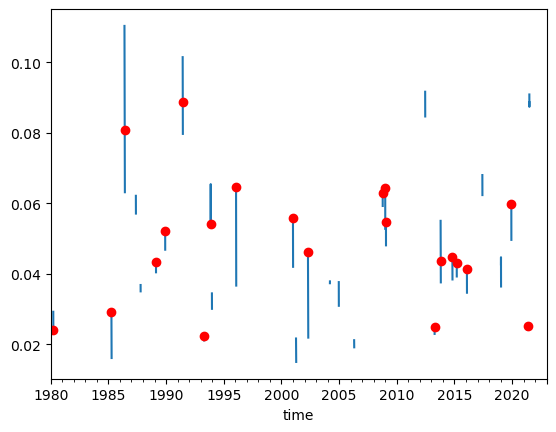

In [226]:
#Plot to visualise where we actually have flash droughts with no overlap compared to all possible dates
df.sm_pct.plot()
df.FD_start.plot(color='r',marker='o')

The red dots now show all the 